In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from pprint import pprint

In [2]:
# URL
renew_energy_url = "https://api.worldbank.org/v2/en/country/all/indicator/EG.FEC.RNEW.ZS?format=json&per_page=20000&source=2"
cntry_url = 'https://restcountries.eu/rest/v2/all'

In [3]:
# Get Renewable Energy Consumption Data
renew_energy_response = requests.get(renew_energy_url).json()
reo = renew_energy_response[1]

# building percent of renewable energy dataframe 
#starting with country
country = [reo[i]['country']['value'] for i in range(len(reo))]
renew_energy_df = pd.DataFrame({'Country':country})

# adding year column to dataframe
year= [reo[i]['date'] for i in range(len(reo))]
renew_energy_df["Year"]= year

# adding alphacode column to dataframe
a_code = [reo[i]['countryiso3code'] for i in range(len(reo))]
renew_energy_df["alpha3code"]= a_code

# adding Percent Renewable value to dataframe
percent_renewable = [reo[i]['value'] for i in range(len(reo))]
renew_energy_df["Percent Renewable"]= percent_renewable

# dropping rows with blank alphacodes - maybe this will do the trick to remove all "non-countries"
renew_energy_df = renew_energy_df[renew_energy_df.alpha3code != ""]

# reomving all nan values for percent renewable
renew_energy_df = renew_energy_df[np.isfinite(renew_energy_df['Percent Renewable'])]

# Changing Year column dtype to float

renew_energy_df["Year"] = pd.to_numeric(renew_energy_df["Year"])

# limiting years to 2000-2015

renew_energy_df = renew_energy_df.drop(renew_energy_df[(renew_energy_df.Year < 2000) | (renew_energy_df.Year > 2015)].index)
#renew_energy_df = renew_energy_df.drop(columns=["alpha3code"])

renew_energy_df.columns=["Country", "Year", "Code", "Percent Renewable"]
renew_energy_df.head()

,Country,Year,Code,Percent Renewable
2776,Afghanistan,2015,AFG,18.423477
2777,Afghanistan,2014,AFG,19.314269
2778,Afghanistan,2013,AFG,16.334293
2779,Afghanistan,2012,AFG,13.973586
2780,Afghanistan,2011,AFG,11.482706


In [4]:
# Get Countries, Lat, Long Data
cntry_response = requests.get(cntry_url).json()

# Process each country and store details in a list
cntry_ls = []
for index, each in enumerate(cntry_response):
    try:
        c_name = each['name']
        c_code = each['alpha3Code']
        c_lat = each['latlng'][0]
        c_lng = each['latlng'][1]
        c_pop = each['population']
        c_area = each['area']
        c_details = [c_name, c_code, c_pop, c_area, c_lat, c_lng]
        cntry_ls.append(c_details)
    except:
        print(f"Data not found for {c_name}")

# Convert list to dataframe        
cntry_df = pd.DataFrame(cntry_ls, columns=["Country", "Code", "Population", "Area", "Lat", "Lng"])

# Convert data to numeric
cntry_df["Population"] = pd.to_numeric(cntry_df["Population"])
cntry_df["Area"] = pd.to_numeric(cntry_df["Area"])
cntry_df["Lat"] = pd.to_numeric(cntry_df["Lat"])
cntry_df["Lng"] = pd.to_numeric(cntry_df["Lng"])

# Cross Join year
years = []
for i in range(2000, 2016, 1):
    years.append(i)
years_df = pd.DataFrame(years, columns=["Year"])
years_df

cntry_df['dummykey'] = 0
years_df['dummykey'] = 0

countries_df = cntry_df.merge(years_df, how='outer')

countries_df = countries_df.drop(columns=["dummykey"])
countries_df.head()

Data not found for United States Minor Outlying Islands


,Country,Code,Population,Area,Lat,Lng,Year
0,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2000
1,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2001
2,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2002
3,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2003
4,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2004


In [5]:
# Get Emission data
emm_df = pd.read_csv("EmissionData.csv", skiprows=4)

# Unpivot: Change year columns to rows
emm_df = pd.melt(emm_df, id_vars=['Country Name','Country Code'], value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                       '2012', '2013', '2014', '2015'])
emm_df.columns=["Country", "Code", "Year", "Emission"]
emm_df = emm_df.dropna()
emm_df["Year"] = pd.to_numeric(emm_df["Year"])
emm_df.head()

,Country,Code,Year,Emission
0,Aruba,ABW,2000,26.194875
1,Afghanistan,AFG,2000,0.038506
2,Angola,AGO,2000,0.580353
3,Albania,ALB,2000,0.978175
4,Andorra,AND,2000,8.019284


In [6]:
# Get Consumption data (kwh per capita)
consump_df = pd.read_csv("ConsumptionData.csv", skiprows=4)

# Unpivot: Change year columns to rows
consump_df = pd.melt(consump_df, id_vars=['Country Name','Country Code'], value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                       '2012', '2013', '2014', '2015'])
consump_df.columns=["Country", "Code", "Year", "Consumption"]
consump_df = consump_df.dropna()
consump_df["Year"] = pd.to_numeric(consump_df["Year"])
consump_df.head()

,Country,Code,Year,Consumption
2,Angola,AGO,2000,75.264678
3,Albania,ALB,2000,1449.647413
5,Arab World,ARB,2000,1517.005675
6,United Arab Emirates,ARE,2000,12314.051220
7,Argentina,ARG,2000,2088.808140


In [7]:
# Get Energy Import Data
import_df = pd.read_csv("ImportData.csv", skiprows=4)

# Unpivot: Change year columns to rows
import_df = pd.melt(import_df, id_vars=['Country Name','Country Code'], value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                       '2012', '2013', '2014', '2015'])
import_df.columns=["Country", "Code", "Year", "Import"]
import_df = import_df.dropna()
import_df["Year"] = pd.to_numeric(import_df["Year"])
import_df.head()

,Country,Code,Year,Import
2,Angola,AGO,2000,-504.159002
3,Albania,ALB,2000,45.002409
5,Arab World,ARB,2000,-296.436646
6,United Arab Emirates,ARE,2000,-388.166375
7,Argentina,ARG,2000,-34.652563


In [8]:
# Get Education Data
Ed_df = pd.read_csv("college_ed.csv")

Ed_df.groupby(['Country']).head()

Ed_df = Ed_df.drop(Ed_df[(Ed_df.Year < 2000) | (Ed_df.Year > 2015)].index)
Ed_df.head()

,Country,Code,Year,College Enrolment ratio
14,Afghanistan,AFG,2003,1.25684
15,Afghanistan,AFG,2004,1.25603
16,Afghanistan,AFG,2009,3.90339
17,Afghanistan,AFG,2011,3.75598
18,Afghanistan,AFG,2014,8.66280


In [9]:
# Get GDP Data
gdp_file = 'gdp.csv'
gdp_df = pd.read_csv(gdp_file)

gdp_df.drop(['1960', '1961','1962','1963','1964',
         '1965', '1966','1967', '1968','1969',
         '1970','1971','1972', '1973','1974',
         '1975','1976','1977','1978','1979',
         '1980','1981','1982','1983','1984',
         '1985','1986', '1987','1988','1989',
         '1990', '1991','1992','1993','1994',
         '1995', '1996','1997','1998','1999',
         '2016','2017','2018'], axis=1, inplace=True)

del gdp_df['Indicator Code']
del gdp_df['Indicator Name']

gdp_df =pd.melt(gdp_df, id_vars=['Country Name','Country Code'],value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                                       '2012', '2013', '2014', '2015'])

gdp_df.drop( gdp_df[gdp_df ['value'] == 0.000000 ].index , inplace=True)

gdp_df = gdp_df.rename({'Country Name': 'Country'}, axis=1)
gdp_df = gdp_df.rename({'Country Code': 'Code'}, axis=1)
gdp_df = gdp_df.rename({'value': 'GDP'}, axis=1)
gdp_df = gdp_df.rename({'variable': 'Year'}, axis=1)
gdp_df = gdp_df.dropna(how='any')
gdp_df["Year"] = pd.to_numeric(gdp_df["Year"])
gdp_df.head()

,Country,Code,Year,GDP
0,Aruba,ABW,2000,1.873453e+09
2,Angola,AGO,2000,9.129595e+09
3,Albania,ALB,2000,3.480355e+09
4,Andorra,AND,2000,1.434430e+09
5,Arab World,ARB,2000,7.351881e+11


In [10]:
# Get Renew Energy Kwh data
renew_kwh_df = pd.read_csv("RenewKwh.csv", skiprows=4)

# Unpivot: Change year columns to rows
renew_kwh_df = pd.melt(renew_kwh_df, id_vars=['Country Name','Country Code'], value_vars=['2000', '2001', '2002', '2003', '2004', '2005',
                                                       '2006', '2007', '2008', '2009', '2010', '2011',
                                                       '2012', '2013', '2014', '2015'])
renew_kwh_df.columns=["Country", "Code", "Year", "Renew Kwh"]
renew_kwh_df = renew_kwh_df.dropna()
renew_kwh_df["Year"] = pd.to_numeric(renew_kwh_df["Year"])
renew_kwh_df["Renew Kwh"]=renew_kwh_df["Renew Kwh"]/10000
renew_kwh_df.drop(renew_kwh_df[renew_kwh_df ['Renew Kwh'] == 0.0 ].index , inplace=True)
renew_kwh_df.head()

,Country,Code,Year,Renew Kwh
2,Angola,AGO,2000,1824000.0
3,Albania,ALB,2000,9188000.0
6,Arab League states,ARB,2000,40546000.0
8,Argentina,ARG,2000,58968000.0
9,Armenia,ARM,2000,2522000.0


In [11]:
# Create results with all data combined
result1 = countries_df.merge(renew_energy_df, how='left', on=['Code','Year'])
result1 = result1.drop(columns=["Country_y"])
result1 = result1.rename({'Country_x': 'Country'}, axis=1)

result2 = result1.merge(emm_df, how='left', on=['Code','Year'])
result2 = result2.drop(columns=["Country_y"])
result2 = result2.rename({'Country_x': 'Country'}, axis=1)

result3 = result2.merge(Ed_df, how='left', on=['Code','Year'])
result3 = result3.drop(columns=["Country_y"])
result3 = result3.rename({'Country_x': 'Country'}, axis=1)

result4 = result3.merge(gdp_df, how='left', on=['Code','Year'])
result4 = result4.drop(columns=["Country_y"])
result4 = result4.rename({'Country_x': 'Country'}, axis=1)

result5 = result4.merge(consump_df, how='left', on=['Code','Year'])
result5 = result5.drop(columns=["Country_y"])
result5 = result5.rename({'Country_x': 'Country'}, axis=1)

result6 = result5.merge(import_df, how='left', on=['Code','Year'])
result6 = result6.drop(columns=["Country_y"])
result6 = result6.rename({'Country_x': 'Country'}, axis=1)

result = result6.merge(renew_kwh_df, how='left', on=['Code','Year'])
result = result.drop(columns=["Country_y"])
result = result.rename({'Country_x': 'Country'}, axis=1)

result['GDP'] = result['GDP']/100000

# Drop rows if Percent Renewable is NA
result = result.dropna(subset=['Percent Renewable'])
result.head()

,Country,Code,Population,Area,Lat,Lng,Year,Percent Renewable,Emission,College Enrolment ratio,GDP,Consumption,Import,Renew Kwh
0,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2000,54.243126,0.038506,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2001,54.055055,0.039002,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2002,43.771149,0.048716,NaN,40551.795663,NaN,NaN,NaN
3,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2003,42.276141,0.051830,1.25684,45155.588081,NaN,NaN,NaN
4,Afghanistan,AFG,27657145,652230.0,33.0,65.0,2004,49.843148,0.039378,1.25603,52267.788089,NaN,NaN,NaN


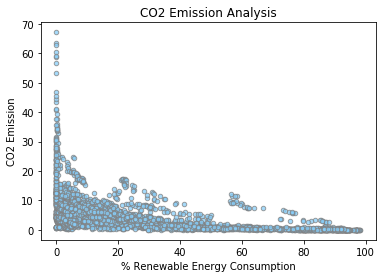

In [12]:
fig, ax = plt.subplots()
result.plot(kind='scatter', x='Percent Renewable', y='Emission', ax=ax, 
           color="lightskyblue", edgecolors="grey", alpha=0.75)
ax.set_title("CO2 Emission Analysis")
ax.set_xlabel("% Renewable Energy Consumption")
ax.set_ylabel("CO2 Emission")
#plt.style.use('fivethirtyeight')
#plt.tight_layout()
#plt.axis("equal")
plt.show()

Text(0, 0.5, 'CO2 Emission')

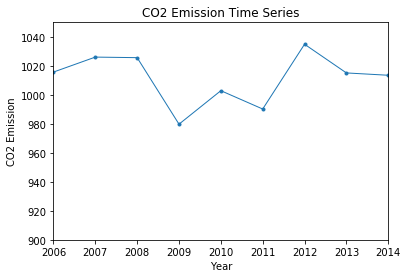

In [13]:
EmmSummary = result.groupby(['Year']).agg({'Emission':'sum'})
EmmSummary = EmmSummary.reset_index()
EmmSummary = EmmSummary.drop(EmmSummary[(EmmSummary.Year < 2006) | (EmmSummary.Year == 2015)].index)

fig, ax = plt.subplots()
#plt.style.use('fivethirtyeight')

EmmSummary.plot(kind='line', x='Year', y='Emission', ax=ax, marker=".", linewidth=1, legend=None)
plt.ylim(900, 1050)
ax.set_title("CO2 Emission Time Series")
ax.set_xlabel("Year")
ax.set_ylabel("CO2 Emission")
#plt.xkcd()


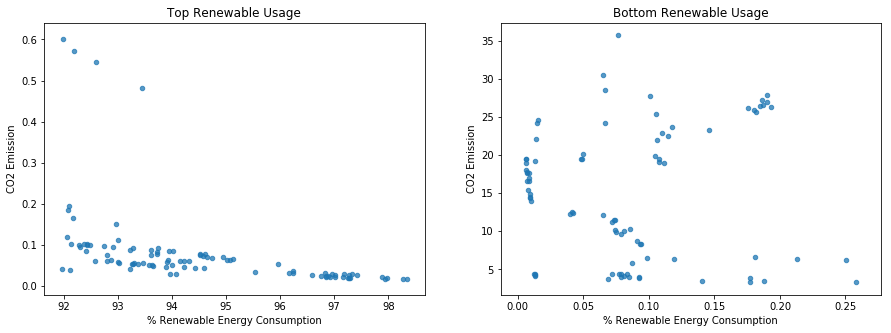

In [14]:
TopRenew = result.sort_values(by="Percent Renewable", ascending=False).head(100)

fig, (ax1, ax2) = plt.subplots(1,2)

TopRenew.plot(kind='scatter', x='Percent Renewable', y='Emission', ax=ax1, 
           alpha=0.75, figsize=(15, 5))
ax1.set_title("Top Renewable Usage")
ax1.set_xlabel("% Renewable Energy Consumption")
ax1.set_ylabel("CO2 Emission")
#plt.style.use('fivethirtyeight')

BottomRenew = result.sort_values(by="Percent Renewable", ascending=True)
BottomRenew.drop(BottomRenew[BottomRenew ['Percent Renewable'] == 0.000000 ].index , inplace=True)
BottomRenew = BottomRenew.head(100)

BottomRenew.plot(kind='scatter', x='Percent Renewable', y='Emission', ax=ax2, alpha=0.75)
ax2.set_title("Bottom Renewable Usage")
ax2.set_xlabel("% Renewable Energy Consumption")
ax2.set_ylabel("CO2 Emission")
#plt.ylim(850, 950)

plt.show()

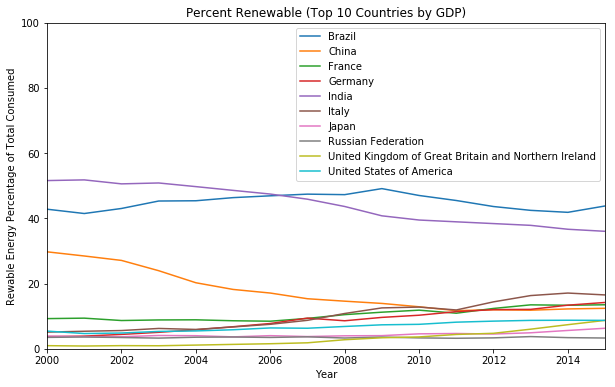

In [15]:
result14 = result.loc[result['Year'] == 2014]
result14 = result14.sort_values(by=['GDP'], ascending = False)
top_10 = result14.head(10)
top_10 = top_10["Country"]
top_10 = top_10.tolist()
top_10 = result.loc[result['Country'].isin(top_10)]
top_10 = top_10.sort_values(by=['Year'])
top_10 = top_10[["Country", "Year", "Percent Renewable"]]
top_10 = top_10.pivot(index = "Year", columns = "Country", values = "Percent Renewable")
top_10.plot(figsize = (10,6))
plt.legend(loc = 'upper right')
plt.title("Percent Renewable (Top 10 Countries by GDP)")
plt.ylabel("Rewable Energy Percentage of Total Consumed")
plt.ylim(0,100)
plt.savefig("Renewable Energy Percentage")

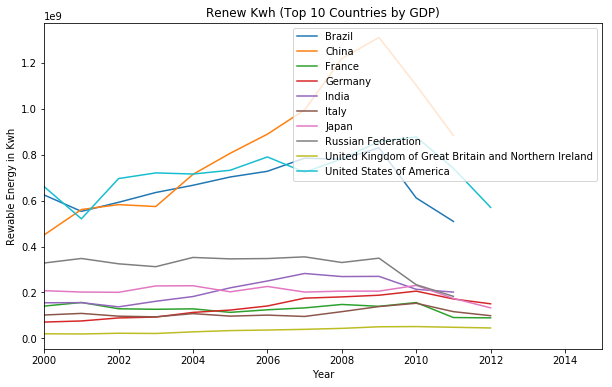

In [16]:
result14 = result.loc[result['Year'] == 2014]
result14 = result14.sort_values(by=['GDP'], ascending = False)
top_10 = result14.head(10)
top_10 = top_10["Country"]
top_10 = top_10.tolist()
top_10 = result.loc[result['Country'].isin(top_10)]
top_10 = top_10.sort_values(by=['Year'])
top_10 = top_10[["Country", "Year", "Renew Kwh"]]
top_10 = top_10.pivot(index = "Year", columns = "Country", values = "Renew Kwh")
top_10.plot(figsize = (10,6))
plt.legend(loc = 'upper right')
plt.title("Renew Kwh (Top 10 Countries by GDP)")
plt.ylabel("Rewable Energy in Kwh")
plt.savefig("Renewable Energy (Kwh)")

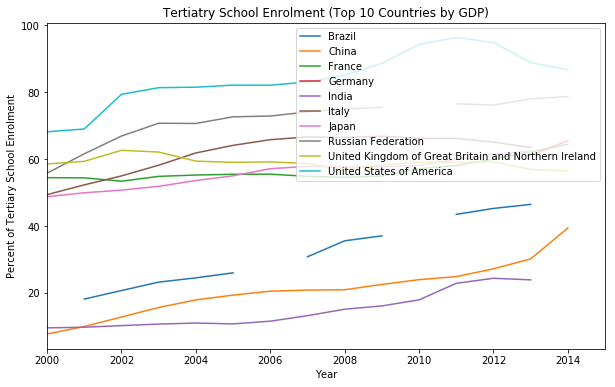

In [17]:
result14 = result.loc[result['Year'] == 2014]
result14 = result14.sort_values(by=['GDP'], ascending = False)
top_10 = result14.head(10)
top_10 = top_10["Country"]
top_10 = top_10.tolist()
top_10 = result.loc[result['Country'].isin(top_10)]
top_10 = top_10.sort_values(by=['Year'])
top_10 = top_10[["Country", "Year", "College Enrolment ratio"]]
top_10 = top_10.pivot(index = "Year", columns = "Country", values = "College Enrolment ratio")
top_10.plot(figsize = (10,6))
plt.legend(loc = 'upper right')
plt.title("Tertiatry School Enrolment (Top 10 Countries by GDP)")
plt.ylabel("Percent of Tertiary School Enrolment")
plt.savefig("Tertiary School Enrolment")

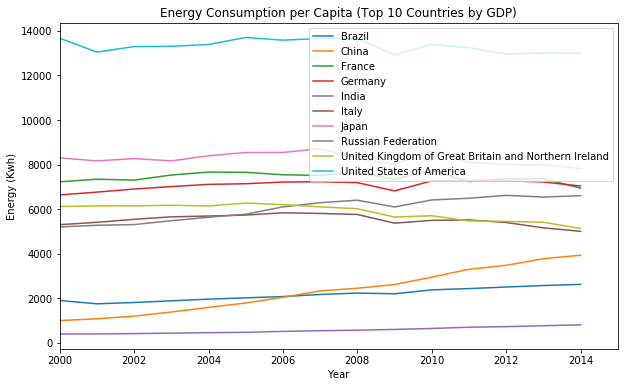

In [18]:
result14 = result.loc[result['Year'] == 2014]
result14 = result14.sort_values(by=['GDP'], ascending = False)
top_10 = result14.head(10)
top_10 = top_10["Country"]
top_10 = top_10.tolist()
top_10 = result.loc[result['Country'].isin(top_10)]
top_10 = top_10.sort_values(by=['Year'])
top_10 = top_10[["Country", "Year", "Consumption"]]
top_10 = top_10.pivot(index = "Year", columns = "Country", values = "Consumption")
top_10.plot(figsize = (10,6))
plt.legend(loc = 'upper right')
plt.title("Energy Consumption per Capita (Top 10 Countries by GDP)")
plt.ylabel("Energy (Kwh)")
plt.savefig("Energy Consumption")

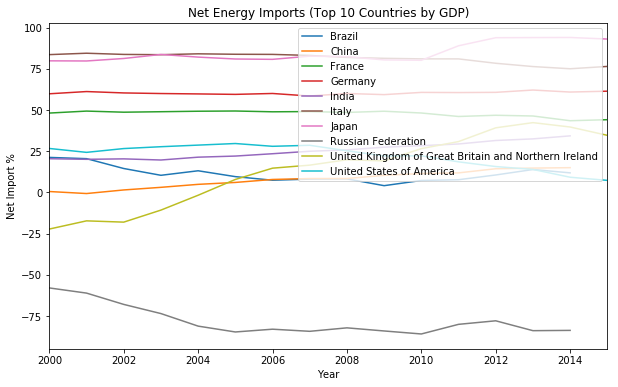

In [19]:
result14 = result.loc[result['Year'] == 2014]
result14 = result14.sort_values(by=['GDP'], ascending = False)
top_10 = result14.head(10)
top_10 = top_10["Country"]
top_10 = top_10.tolist()
top_10 = result.loc[result['Country'].isin(top_10)]
top_10 = top_10.sort_values(by=['Year'])
top_10 = top_10[["Country", "Year", "Import"]]
top_10 = top_10.pivot(index = "Year", columns = "Country", values = "Import")
top_10.plot(figsize = (10,6))
plt.legend(loc = 'upper right')
plt.title("Net Energy Imports (Top 10 Countries by GDP)")
plt.ylabel("Net Import %")
plt.savefig("Net Energy Import")